# SET UP

### IMPORT LIBRARIES

In [1]:
import argparse
import ast
import csv
import itertools
import json
import os
import re

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.linalg as la
from netgraph import InteractiveGraph, Graph
from numpy.linalg import eig
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm

import quantecon as qe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### DEFINE GLOBAL VARIABLE

In [2]:
def getboundaryofamperfromregion(data):
    amperboundaries = {}
    for i in data.index:
        geom = data.at[i, "geometry"]
        pv_name = data.at[i, 'pv_tn']
        re_name = data.at[i, "re_royin"]
        ap_name = data.at[i, 'ap_tn'] if 'ap_tn' in data else ""

        if geom.geom_type == 'Polygon':
            # print("This geometry is a Polygon")
            coordinates_list = list(geom.exterior.coords)
            coordinates_list = [list(coordinate) for coordinate in coordinates_list]

        elif geom.geom_type == 'MultiPolygon':
            polygon_list = list(geom.geoms)  
            coordinates_list = []
            for polygon in polygon_list:
                polygon_coordinates_list = list(polygon.exterior.coords)
                coordinates_list += [list(coordinate) for coordinate in polygon_coordinates_list]

        amperkey = (ap_name, pv_name)
        centroid = geom.centroid
        amperboundaries[amperkey] = {'cor': coordinates_list, 'centroid':centroid}

    return amperboundaries

central = gpd.read_file('data_base/boundary/query-2.geojson')
east = gpd.read_file('data_base/boundary/query-3.geojson')
north = gpd.read_file('data_base/boundary/query-4.geojson')
south = gpd.read_file('data_base/boundary/query-5.geojson')
northeast = gpd.read_file('data_base/boundary/query-6.geojson')
west = gpd.read_file('data_base/boundary/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

central_amperboundaries = getboundaryofamperfromregion(central)
east_amperboundaries = getboundaryofamperfromregion(east)
north_amperboundaries = getboundaryofamperfromregion(north)
south_amperboundaries = getboundaryofamperfromregion(south)
northeast_amperboundaries = getboundaryofamperfromregion(northeast)
west_amperboundaries = getboundaryofamperfromregion(west)

all_amperboundaries = {**central_amperboundaries, **east_amperboundaries, **north_amperboundaries, **south_amperboundaries, **northeast_amperboundaries, **west_amperboundaries}
allampers = list(all_amperboundaries.keys())
DICT_amper2int = {item: index for index, item in enumerate(allampers)}

with open('data_gen/allprovincesTH.txt', 'r', encoding='utf-8') as file:
    allprovinces = []
    for line in file:
        allprovinces.append(line.strip())
DICT_province2int = {item: index for index, item in enumerate(allprovinces)}

# PROVINCES

In [10]:
csvfiles_path = "data_gen_distance_provinces/"  
csvfiles = os.listdir(csvfiles_path)

import pandas as pd
 
df_list= []
total = 0

for csvfile in csvfiles:
    if csvfile.split(".")[-1] == 'csv':
        csvfile_path = csvfiles_path+ csvfile
        df = pd.read_csv(csvfile_path)
        df_list.append(df)
        N = len(df)
        total  +=N

result = pd.concat(df_list, ignore_index=True)
result = result[["original", "destination", "distance"]]
result.to_csv("data_final/provinces_distance.csv")

## GEN PROVINC ADJACENCTY AND DISTANCE MATRIX

In [65]:
import pandas as pd
import numpy as np

provinces_lat_lon_df = pd.read_csv("data_gen/provinces_lat_lon.csv")

A = np.zeros([len(provinces_lat_lon_df),len(provinces_lat_lon_df)])
D = np.zeros([len(provinces_lat_lon_df),len(provinces_lat_lon_df)])

original_destination_df = pd.read_csv("data_gen_distance_provinces/provinces_distanceTH.csv")
for i in range(len(original_destination_df)):
    original_province_name = original_destination_df.iloc[i]["original"]
    destination_province_name = original_destination_df.iloc[i]["destination"]
    distance = original_destination_df.iloc[i]["distance"].replace("km", "").replace(" ", "")

    original_index = DICT_province2int[original_province_name]
    destination_index = DICT_province2int[destination_province_name]
    A[original_index, destination_index] = 1
    D[original_index, destination_index] = distance

## PROVINCE VISUALIZATION

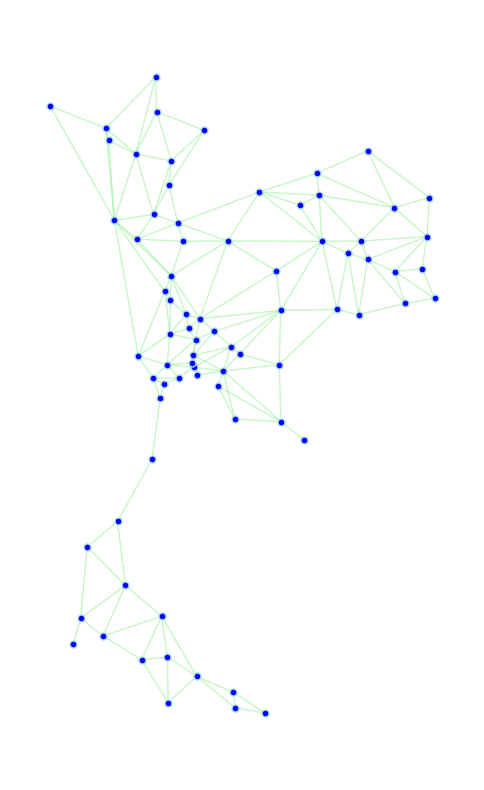

In [6]:
provinces_lat_lon_df = pd.read_csv("data_gen/provinces_lat_lon.csv")
positions = dict()
for i in range(len(provinces_lat_lon_df)):
    #จังหวัด,Lat,Lon
    provincename = provinces_lat_lon_df.iloc[i]["จังหวัด"]
    Lat = provinces_lat_lon_df.iloc[i]["Lat"]
    Lon = provinces_lat_lon_df.iloc[i]["Lon"]

    province_index = DICT_province2int[provincename]
    positions[province_index] = (Lon, Lat)

G = nx.from_numpy_array(A)


nx.draw_networkx_edges(G, positions, alpha=0.5, edge_color='lightgreen', width =1)
nx.draw_networkx_nodes(G, positions, node_color='blue', node_size=25, edgecolors='lightblue', linewidths=1)

# nx.draw_networkx_labels(G, positions, labels=labels, font_size=8, font_family='sans-serif')
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='blue', node_size=800, font_size=15)

plt.axis('off')  # Removes the axis for a cleaner look
plt.gcf().set_size_inches(6, 10)  # Adjust the figure size if necessary for better visibility
 
plt.show()

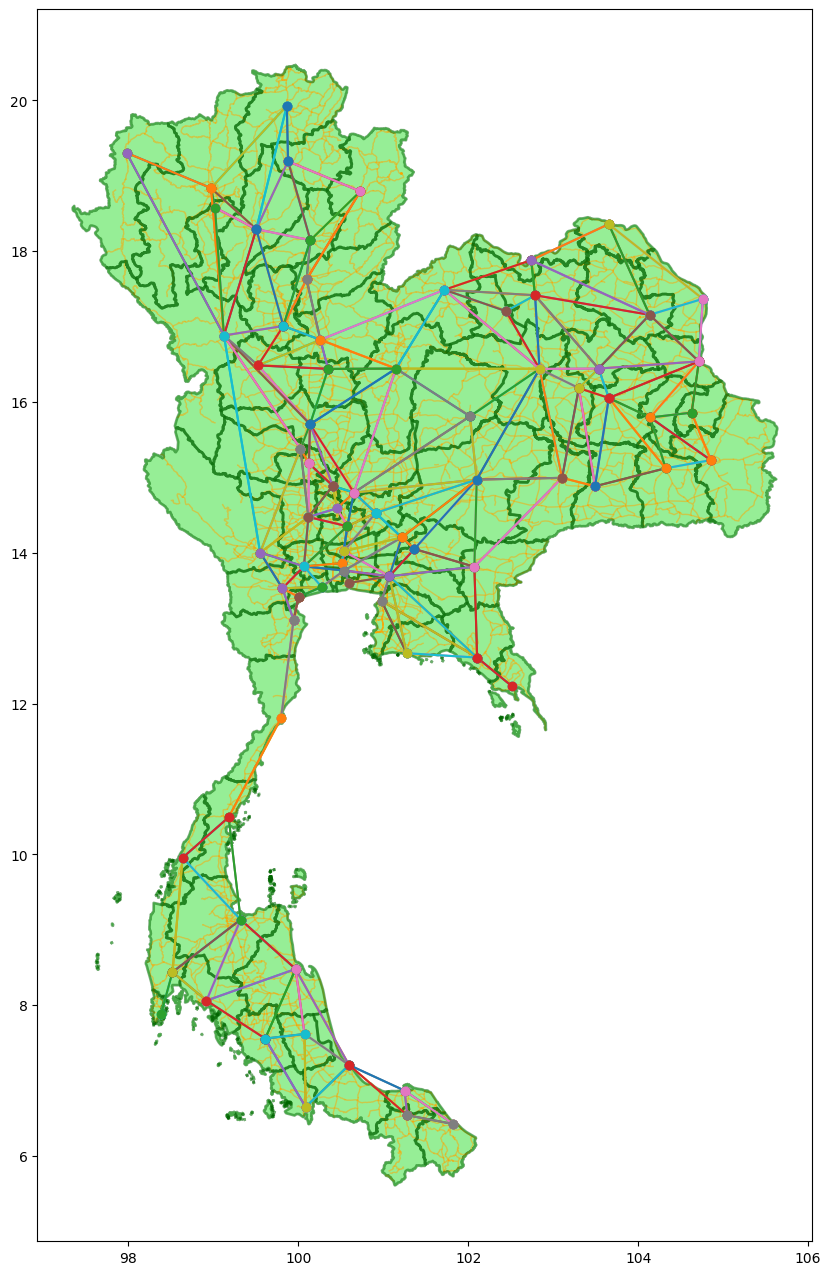

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### MAIN PLOT ###
fig, ax = plt.subplots(figsize=(10, 16))


### ROAD ###
DATA_FOLDER = "data_base/road/"
file_paths_list = [
    "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
    "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
    "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
    "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
    "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
    "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
]

road_color = 'orange'
road_width = 1
road_alpha = 0.5

for file_path in file_paths_list:
    roads = gpd.read_file(DATA_FOLDER + file_path)
    for x, y in roads.geometry.apply(lambda geom: zip(*geom.coords)):
        ax.plot(x, y, color=road_color, alpha=road_alpha, linewidth=road_width)

provinces = gpd.read_file('data_base/boundary/query.geojson')

# cmap = plt.cm.get_cmap('winter', len(provinces))  # Choose any available colormap
fillcolor = "lightgreen"
for i in range(len(provinces['pv_tn'])):
    geom = provinces["geometry"][i]
    pv_name = provinces['pv_tn'][i]

    # fillcolor = mcolors.to_hex(cmap(i))
    plot_settings = {'color': fillcolor, 'alpha': 0.95}

    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='darkgreen', alpha=0.5,  linewidth=2)
        ax.fill(x, y, **plot_settings)


    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms: 
            x, y = polygon.exterior.xy
            ax.plot(x, y, color='darkgreen', alpha=0.5, linewidth=2)    
            ax.fill(x, y, **plot_settings)
    

# PLOT EDGES
csvfile_path = "data_gen_adjacency_provinces/adjacency_provinces.csv"  
df = pd.read_csv(csvfile_path)
N = len(df)
for i in range(N):

    province1 =  df.iloc[i]["province1"]
    province2  = df.iloc[i]["province2"]

    province1_index = DICT_province2int[province1]
    province2_index = DICT_province2int[province2]
    province1_position = positions[province1_index]
    province2_position = positions[province2_index]
    
    x_values = [province1_position[0], province2_position[0]]
    y_values = [province1_position[1], province2_position[1]]

    ax.plot(x_values, y_values, marker='o', linestyle='-')

## PLOT NODES
# for i in range(len(provinces['pv_tn'])):
#     centerx, centery = positions[DICT_province2int[pv_name]]
#     ax.plot(centerx, centery, 'o', color='blue', alpha=0.5, markersize=10)

plt.show()

## PROVINCE USE CASE: COMMUNITY DETECTION

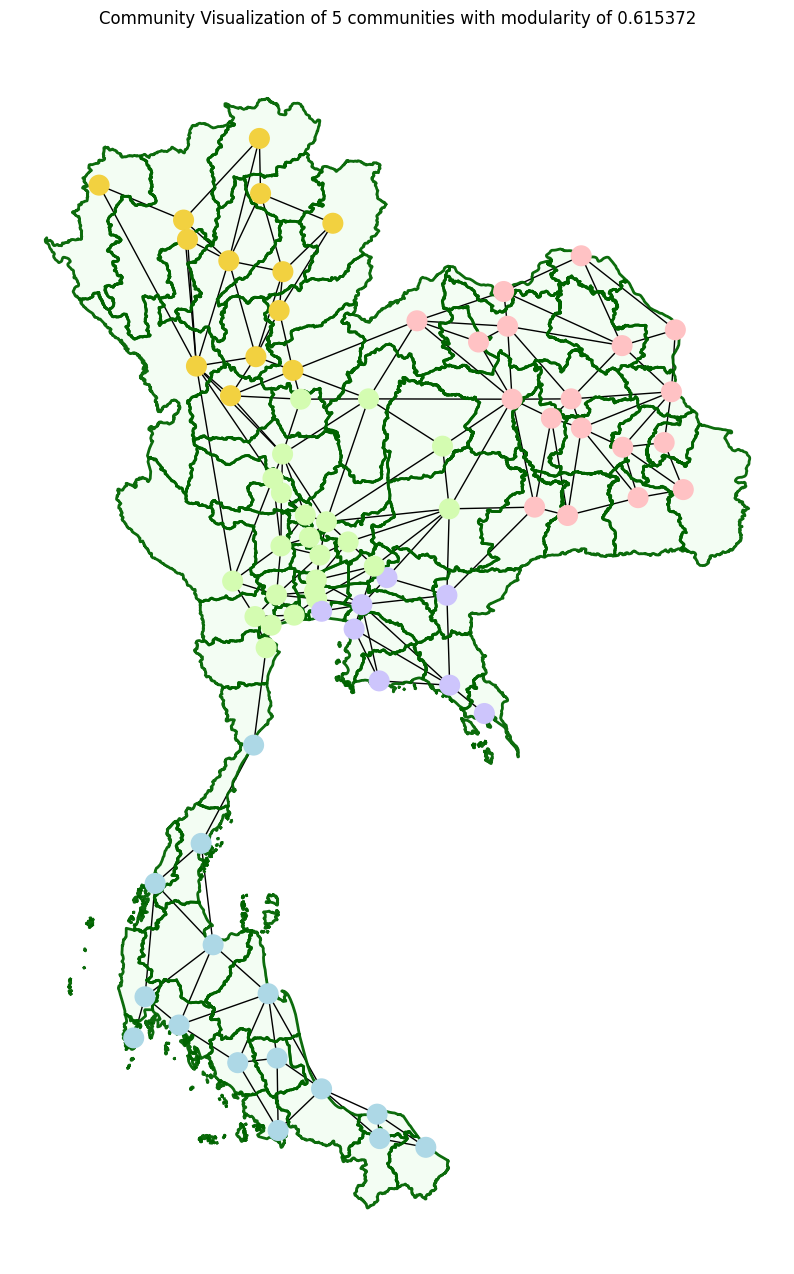

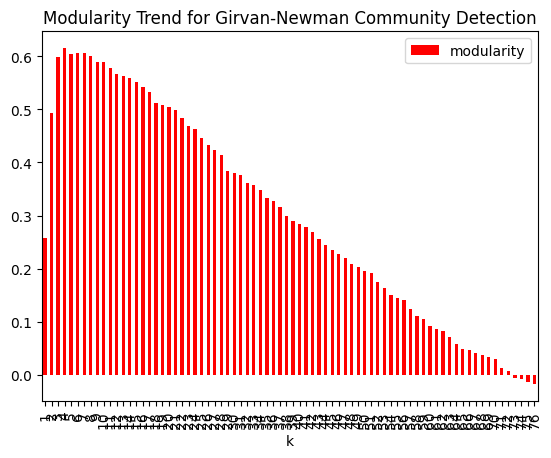

In [69]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

G = nx.from_numpy_array(D)
# Load karate graph and find communities using Girvan-Newman
# G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "lightblue"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

def visualize_communities(graph, communities):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    # pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    # plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=positions,
        node_size=200,
        node_color=node_colors,
        with_labels=False,
        font_size=20,
        font_color="black",
    )

fig, ax = plt.subplots(figsize=(10, 16))

for i in range(len(provinces['pv_tn'])):
    geom = provinces["geometry"][i]
    pv_name = provinces['pv_tn'][i]

    # fillcolor = mcolors.to_hex(cmap(i))
    plot_settings = {'color': fillcolor, 'alpha': 0.1}

    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='darkgreen', alpha=0.95,  linewidth=2)
        ax.fill(x, y, **plot_settings)


    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms: 
            x, y = polygon.exterior.xy
            ax.plot(x, y, color='darkgreen', alpha=0.95, linewidth=2)    
            # plot_settings = {'color': fillcolor, 'alpha': 0.1}
            ax.fill(x, y, **plot_settings)

visualize_communities(G, communities[3]) 

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    # ax=ax,
    color="red",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()

# DISTRICTS

### VISUALIZATION 

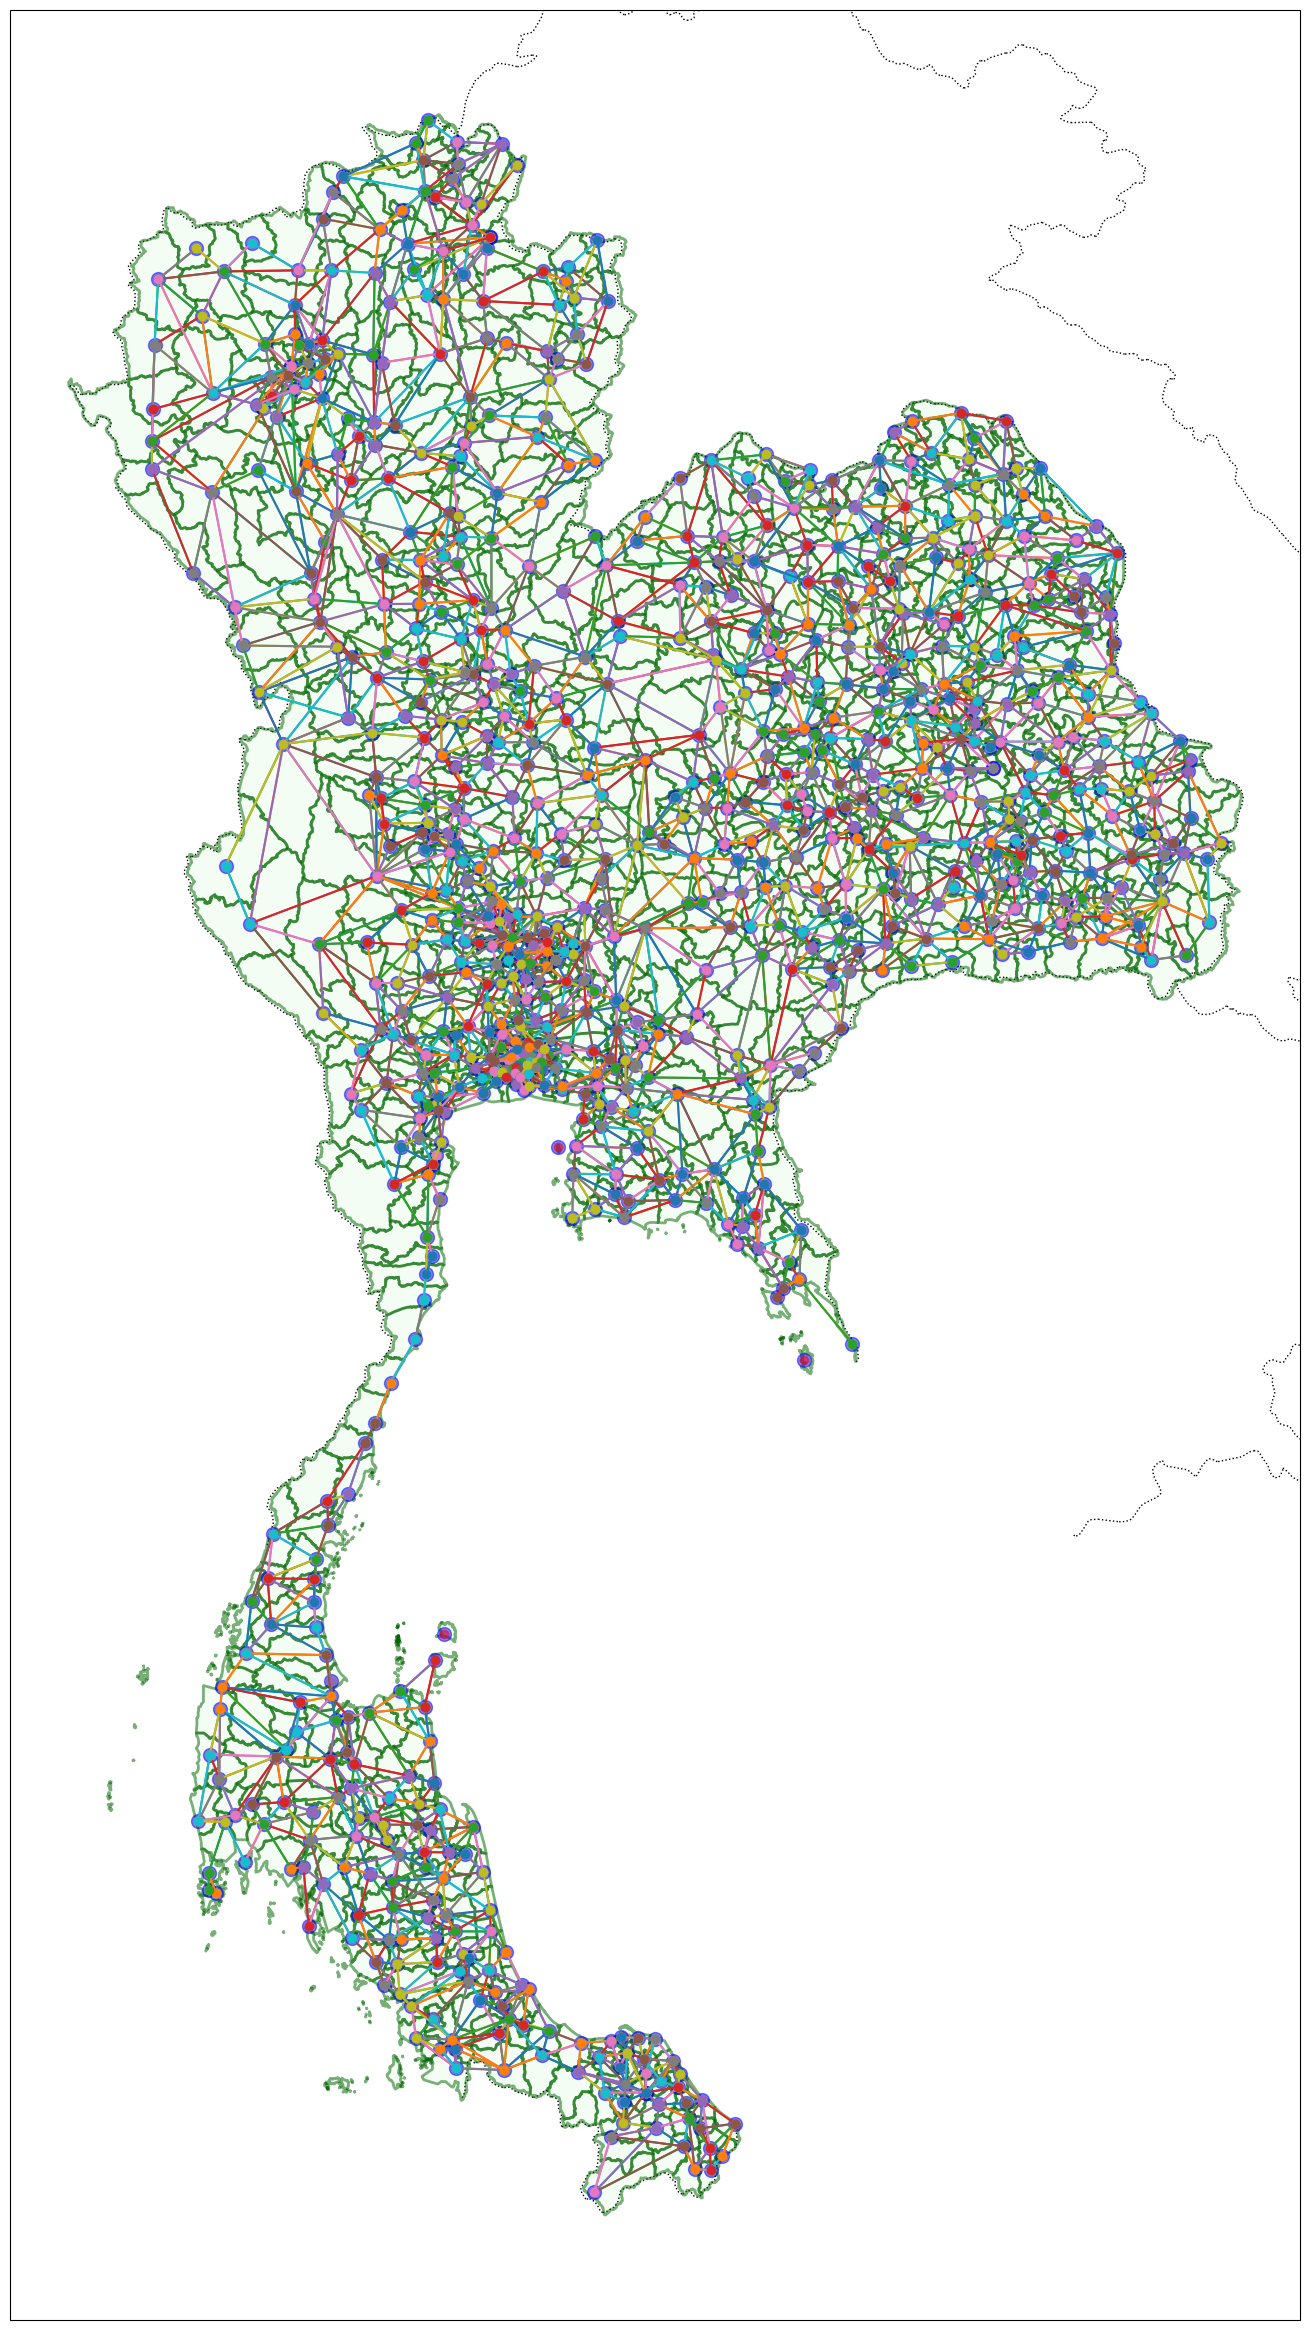

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd

allampers_collected_df = pd.read_csv("data_gen/allampers_collected.csv")

ampers_positions = dict()

for i in range(len(allampers_collected_df)):
    amper_name = allampers_collected_df.iloc[i]["Amper TH"]
    province_name =  allampers_collected_df.iloc[i]["Province TH"]
    lat = allampers_collected_df.iloc[i]["Lat"]
    lon = allampers_collected_df.iloc[i]["Lon"]
    amper_tuple = (amper_name, province_name)
    ampers_positions[DICT_amper2int[amper_tuple]] = (lon,lat)

# # Define map appearance
plt.figure(figsize=(20, 30))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1) 

# Define colors and widths for clarity and consistency
region_edge_color = 'green'
river_color = 'blue'
road_color = 'grey'
road_width = 3
road_alpha = 0.5

central = gpd.read_file('data_base/boundary/query-2.geojson')
east = gpd.read_file('data_base/boundary/query-3.geojson')
north = gpd.read_file('data_base/boundary/query-4.geojson')
south = gpd.read_file('data_base/boundary/query-5.geojson')
northeast = gpd.read_file('data_base/boundary/query-6.geojson')
west = gpd.read_file('data_base/boundary/query-7.geojson')

regions = [central, east, north, south, northeast, west]

# cmap = plt.cm.get_cmap('winter', len(allampers))
for region in regions:
      # Choose any available colormap
    for i in range(len(region['ap_tn'])):
        geom = region["geometry"][i]
        ap_tn = region['ap_tn'][i]
        pv_tn = region['pv_tn'][i]

        amper_tuple = (ap_tn, pv_tn)

        # color = mcolors.to_hex(cmap(i))
        plot_settings = {'color': "lightgreen", 'alpha': 0.1}
        
        if geom.geom_type == 'Polygon':
            x, y = geom.exterior.xy
            ax.plot(x, y, color='darkgreen', alpha=0.5,  linewidth=2)
            ax.fill(x, y, **plot_settings)

        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms: 
                x, y = polygon.exterior.xy
                ax.plot(x, y, color='darkgreen', alpha=0.5, linewidth=2)    
                ax.fill(x, y, **plot_settings)
        
        centerx, centery = ampers_positions[DICT_amper2int[amper_tuple]]
        ax.plot(centerx, centery, 'o', color='blue', alpha=0.5, markersize=10)

# for region in regions:
#     ax.add_geometries(region['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=region_edge_color)

for lat, lon in zip(allampers_collected_df['Lat'], allampers_collected_df['Lon']):
    ax.plot(lon, lat, 'o', color='red', alpha=0.5)

csvfiles_path = "data_gen_adjacency_districts/"  
csvfiles = os.listdir(csvfiles_path)
for csvfile in csvfiles:
    csvfile_path = csvfiles_path+ csvfile
    df = pd.read_csv(csvfile_path)
    N = len(df)
    for i in range(N):

        amper1_tuple = ast.literal_eval(df.iloc[i]["Amper1"])
        amper2_tuple  = ast.literal_eval(df.iloc[i]["Amper2"])
        amper1_index = DICT_amper2int[amper1_tuple]
        amper2_index = DICT_amper2int[amper2_tuple]

        amper1_position = ampers_positions[amper1_index]
        amper2_position = ampers_positions[amper2_index]
        
        x_values = [amper1_position[0], amper2_position[0]]
        y_values = [amper1_position[1], amper2_position[1]]

        ax.plot(x_values, y_values, marker='o', linestyle='-')
        plot_settings = {'color': fillcolor, 'alpha': 0.1}

# # Add river geometries
# rivers = gpd.read_file("data_base/road/2022-08-17-filter.geojson").to_crs(epsg=4326)
# ax.add_geometries(rivers['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=river_color)

# Define road file paths
# DATA_FOLDER = "data_base/road/"
# file_paths_list = [
#      "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
#      "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
#      "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
#      "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
#      "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
#      "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
#  ]

# # # Add road data
# for file_path in file_paths_list:
#     roads = gpd.read_file(DATA_FOLDER + file_path)
#     for x, y in roads.geometry.apply(lambda geom: zip(*geom.coords)):
#         ax.plot(x, y, color=road_color, alpha=road_alpha, linewidth=road_width)

plt.show()

### ADJACENCY MATRIX

In [90]:
## GEN DISTRICTS DISTANCE

csvfiles_path = "data_gen_distance_districts/"  
csvfiles = os.listdir(csvfiles_path)

import pandas as pd
 
df_list= []
total = 0

for csvfile in csvfiles:
    if csvfile.split(".")[-1] == 'csv':
        csvfile_path = csvfiles_path+ csvfile
        df = pd.read_csv(csvfile_path)
        df_list.append(df)
        N = len(df)
        total  +=N

result = pd.concat(df_list, ignore_index=True)
result = result[["original_tuple", "destination_tuple", "distance"]]
result.to_csv("data_final/district_distance.csv")

### Adjacency and Distance Matrix

In [59]:
district_distance_df = pd.read_csv("data_final/district_distance.csv")
N_districts = len(allampers) 
A = np.zeros([N_districts, N_districts])
D = np.zeros([N_districts, N_districts])
for i in range(len(district_distance_df)):
    original_tuple = ast.literal_eval(district_distance_df.iloc[i]['original_tuple'])
    original_index = DICT_amper2int[original_tuple]
    destination_tuple = ast.literal_eval(district_distance_df.iloc[i]['destination_tuple'])
    destination_index = DICT_amper2int[destination_tuple]

    distance = float(district_distance_df.iloc[i]['distance'].replace("km", "").replace(" ", ""))

    A[original_index, destination_index] = 1
    D[original_index, destination_index] = distance

## DISTRICT USE CASES

### DEGREE CENTRALITY

In [30]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[district]+1 for district in allampers], 
    'district': allampers
}) 


df['district'] = [allampers[i] for i in range(len(allampers))]

centralities = nx.degree_centrality(G)

centrality_list = [value for value in centralities.values()]
df['degree'] = centrality_list

df.to_csv("usecases/province_centrality_degree.csv", encoding='utf-8-sig')

In [50]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[district]+1 for district in allampers], 
    'district': allampers
}) 

df['district'] = [allampers[i] for i in range(len(allampers))]

centralities = nx.eigenvector_centrality(G, weight='weight', max_iter=10000)

centrality_list = [value for value in centralities.values()]
df['eigenvector'] = centrality_list

df.to_csv("usecases/province_centrality_eigenvector_adjacency.csv", encoding='utf-8-sig')

In [60]:
D

array([[ 0. ,  4.5,  8. , ...,  0. ,  0. ,  0. ],
       [ 3.6,  0. ,  7.1, ...,  0. ,  0. ,  0. ],
       [ 8.2,  7.8,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 16. ],
       [ 0. ,  0. ,  0. , ...,  0. , 16.2,  0. ]])

In [63]:
D_normalized =  np.zeros([D.shape[0], D.shape[0]])

# for i in range(D.shape[0]):
#     for j in range(D.shape[0]):
#         if D[i,j] > 500:
#             D[i,j] = 0

Dmax = D.max()
for i in range(D.shape[0]):
    for j in range(D.shape[0]):
        if D[i,j] != 0:
            D_normalized[i,j] = 1/D[i,j] 

D_normalized = (D_normalized+D_normalized.T)/2
D_normalized

array([[0.        , 0.25      , 0.12347561, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.        , 0.1345251 , ..., 0.        , 0.        ,
        0.        ],
       [0.12347561, 0.1345251 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0621142 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0621142 ,
        0.        ]])

In [64]:
G = nx.from_numpy_array(D_normalized) 

df = pd.DataFrame({
    'index': [DICT_amper2int[district]+1 for district in allampers], 
    'district': allampers
}) 

centralities = nx.eigenvector_centrality(G, weight='weight', max_iter=100000)

centrality_list = [value for value in centralities.values()]

df['eigenvector'] = centrality_list

df.to_csv("usecases/province_centrality_eigenvector_distance.csv", encoding='utf-8-sig')

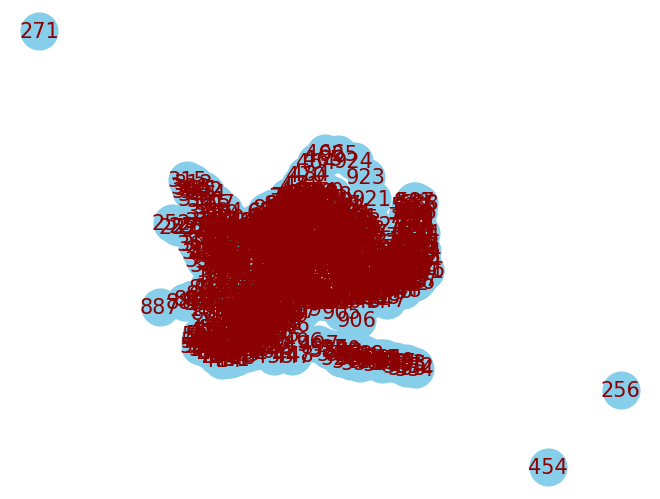

In [48]:
# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='#FF5733', font_size=15, font_color='darkred')

# Show the plot
plt.show()